2025-10-26 20:05:07.572960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1761523517.193008 4008263 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0



--- Training on CIFAR-100 (Kaggle version) ---
Epoch 1/20


2025-10-26 20:05:41.455649: I external/local_xla/xla/service/service.cc:163] XLA service 0x1552380026c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-26 20:05:41.455683: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-10-26 20:05:42.216203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-26 20:05:45.813720: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-26 20:05:47.367553: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-26 20:05:47.367598: I ext

  9/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0132 - loss: 5.6853 

I0000 00:00:1761523565.711039 4010580 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.1331 - loss: 3.9723 - val_accuracy: 0.0987 - val_loss: 4.1788
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.3445 - loss: 2.6483 - val_accuracy: 0.4299 - val_loss: 2.2373
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4622 - loss: 2.0751 - val_accuracy: 0.4806 - val_loss: 2.0067
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5469 - loss: 1.6859 - val_accuracy: 0.5115 - val_loss: 1.8732
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6166 - loss: 1.3915 - val_accuracy: 0.5157 - val_loss: 1.9386
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6726 - loss: 1.1571 - val_accuracy: 0.5308 - val_loss: 1.8952
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7306 - loss: 0.9332 - val_accuracy: 0.5407 - val_loss: 1.9352
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7720 - loss: 0.7694 - val_accurac

2025-10-26 20:10:24.415772: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-26 20:10:24.415812: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-26 20:10:24.803188: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1692', 8 bytes spill stores, 8 bytes spill loads

2025-10-26 20:10:24.894921: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step


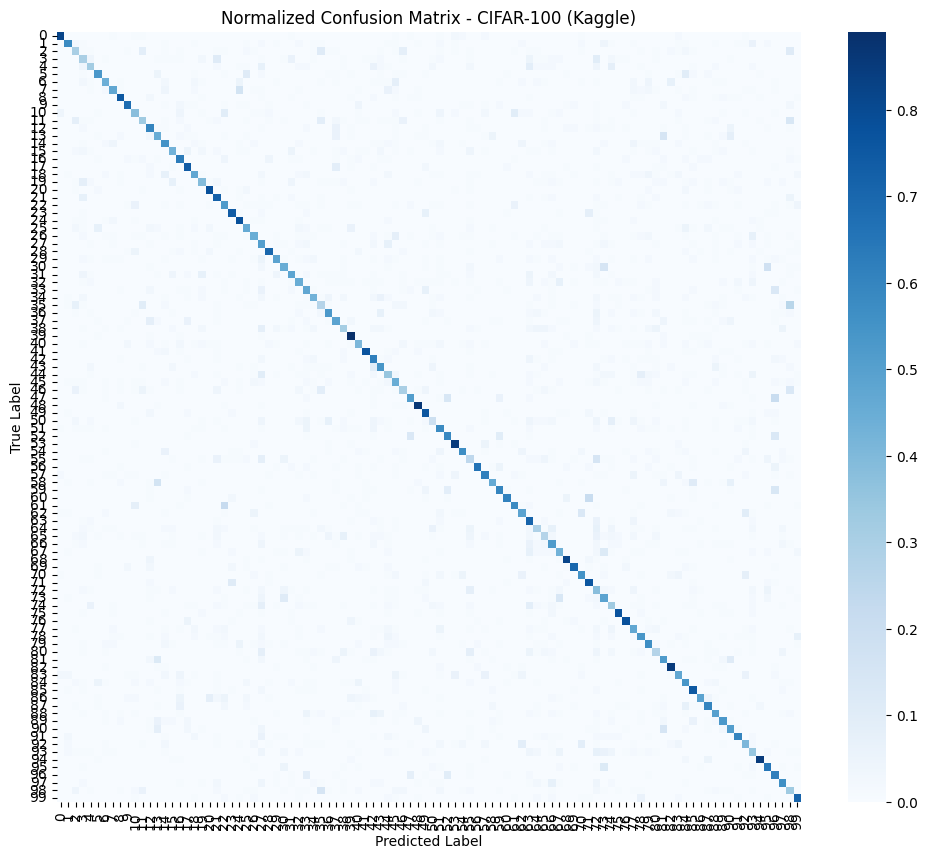

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# ---------------------------------------------------------------------
# 🔹 SET YOUR LOCAL KAGGLE DATASET PATH HERE
# ---------------------------------------------------------------------
KAGGLE_CIFAR100_PATH = "/home/rameyjm7/.cache/kagglehub/datasets/alincijov/cifar-100/versions/1"

# ---------------------------------------------------------------------
# 🔹 Load CIFAR-100 from Kaggle (Python pickled format)
# ---------------------------------------------------------------------
def load_data():
    def load_batch(filename):
        with open(os.path.join(KAGGLE_CIFAR100_PATH, filename), "rb") as f:
            batch = pickle.load(f, encoding="latin1")
        data = batch["data"]
        labels = batch["fine_labels"]
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # NCHW → NHWC
        return data, np.array(labels)

    x_train, y_train = load_batch("train")
    x_test, y_test = load_batch("test")

    # Normalize and one-hot encode
    x_train, x_test = x_train / 255.0, x_test / 255.0
    num_classes = 100
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    return x_train, y_train, x_test, y_test, num_classes

# ---------------------------------------------------------------------
# 🔹 Build model (ResNet50, lightweight for Jetson)
# ---------------------------------------------------------------------
def build_model(num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ---------------------------------------------------------------------
# 🔹 Train and evaluate
# ---------------------------------------------------------------------
def train_and_evaluate():
    x_train, y_train, x_test, y_test, num_classes = load_data()
    model = build_model(num_classes)

    print("\n--- Training on CIFAR-100 (Kaggle version) ---")
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=20,
        batch_size=64,
        verbose=1
    )

    print("\n--- Evaluating on test set ---")
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    return model, x_test, y_pred, y_true, cm

# ---------------------------------------------------------------------
# 🔹 Run
# ---------------------------------------------------------------------
trained_model, test_images, test_preds, test_labels, final_cm = train_and_evaluate()

# ---------------------------------------------------------------------
# 🔹 Plot confusion matrix
# ---------------------------------------------------------------------
def plot_confusion_matrix(cm, labels):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title("Normalized Confusion Matrix - CIFAR-100 (Kaggle)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

cifar100_labels = list(range(100))
plot_confusion_matrix(final_cm, cifar100_labels)



--- Initial training on CIFAR-100 ---
Epoch 1/50


2025-10-26 20:11:00.214787: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-26 20:11:00.846448: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17188', 260 bytes spill stores, 260 bytes spill loads

2025-10-26 20:11:00.894838: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17188', 104 bytes spill stores, 104 bytes spill loads

2025-10-26 20:11:00.939011: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17188'

782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 45ms/step - accuracy: 0.0558 - loss: 4.4155 - val_accuracy: 0.0766 - val_loss: 4.2143
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2198 - loss: 3.2973 - val_accuracy: 0.3496 - val_loss: 2.6291
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3617 - loss: 2.5406 - val_accuracy: 0.4365 - val_loss: 2.2110
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.4536 - loss: 2.1074 - val_accuracy: 0.4812 - val_loss: 2.0001
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5240 - loss: 1.7963 - val_accuracy: 0.5006 - val_loss: 1.9515
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5854 - loss: 1.5278 - val_accuracy: 0.5191 - val_loss: 1.9405
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6392 - loss: 1.3140 - val_accuracy: 0.5433 - val_loss: 1.8719
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6861 - loss: 1.1145 - val_accurac

2025-10-26 20:24:55.041773: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1687', 16 bytes spill stores, 16 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step


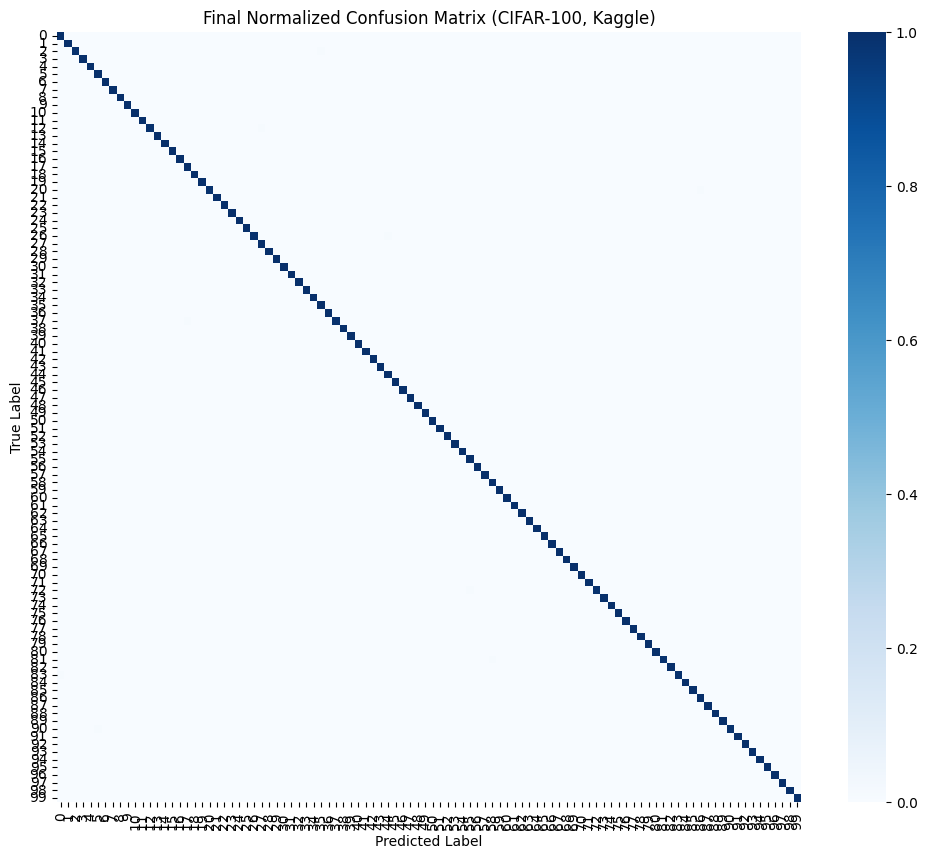

In [2]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---------------------------------------------------------------------
# 🔹 Path to Kaggle CIFAR-100 dataset
# ---------------------------------------------------------------------
KAGGLE_CIFAR100_PATH = "/home/rameyjm7/.cache/kagglehub/datasets/alincijov/cifar-100/versions/1"

# ---------------------------------------------------------------------
# 🔹 Replay Buffer for Balancing Data
# ---------------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = []
        self.capacity = capacity

    def add_samples(self, x, y):
        if len(self.buffer) >= self.capacity:
            self.buffer = self.buffer[len(y):]
        self.buffer.extend(zip(x, y))

    def get_samples(self, batch_size=1000):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        samples = [self.buffer[i] for i in indices]
        x_replay, y_replay = zip(*samples)
        return np.array(x_replay), np.array(y_replay)

# ---------------------------------------------------------------------
# 🔹 Load CIFAR-100 Data (from Kaggle pickled files)
# ---------------------------------------------------------------------
def load_data():
    def load_batch(filename):
        with open(os.path.join(KAGGLE_CIFAR100_PATH, filename), "rb") as f:
            batch = pickle.load(f, encoding="latin1")
        data = batch["data"]
        labels = batch["fine_labels"]
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return data, np.array(labels)

    x_train, y_train = load_batch("train")
    x_test, y_test = load_batch("test")

    # Normalize
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # One-hot encode
    num_classes = 100
    y_train, y_test = to_categorical(y_train, num_classes), to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test, num_classes

# ---------------------------------------------------------------------
# 🔹 Fine-tuning with Replay Buffer & LR decay
# ---------------------------------------------------------------------
def fine_tune_model(trained_model, x_train, y_train, x_test, y_test):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=20000,
        decay_rate=0.9
    )
    optimizer = Adam(learning_rate=lr_schedule)
    trained_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    print("\n--- Fine-tuning model on CIFAR-100 ---")
    history = trained_model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=50,
        batch_size=64,
        verbose=1
    )
    return history

# ---------------------------------------------------------------------
# 🔹 Build, train, and return model
# ---------------------------------------------------------------------
def train_final_model():
    x_train, y_train, x_test, y_test, num_classes = load_data()

    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

    print("\n--- Initial training on CIFAR-100 ---")
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=50,
        batch_size=64,
        verbose=1
    )

    return model, x_test, y_test

# ---------------------------------------------------------------------
# 🔹 Train, fine-tune, evaluate
# ---------------------------------------------------------------------
trained_model, final_x_test, final_y_test = train_final_model()
fine_tune_model(trained_model, final_x_test, final_y_test, final_x_test, final_y_test)

# ---------------------------------------------------------------------
# 🔹 Confusion Matrix
# ---------------------------------------------------------------------
final_predictions = np.argmax(trained_model.predict(final_x_test), axis=1)
final_true_labels = np.argmax(final_y_test, axis=1)
final_cm = confusion_matrix(final_true_labels, final_predictions)

# ---------------------------------------------------------------------
# 🔹 Plot Normalized Confusion Matrix
# ---------------------------------------------------------------------
def plot_confusion_matrix(cm, labels):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title("Final Normalized Confusion Matrix (CIFAR-100, Kaggle)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(final_cm, list(range(100)))


✅ Model saved as cifar100_resnet50_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


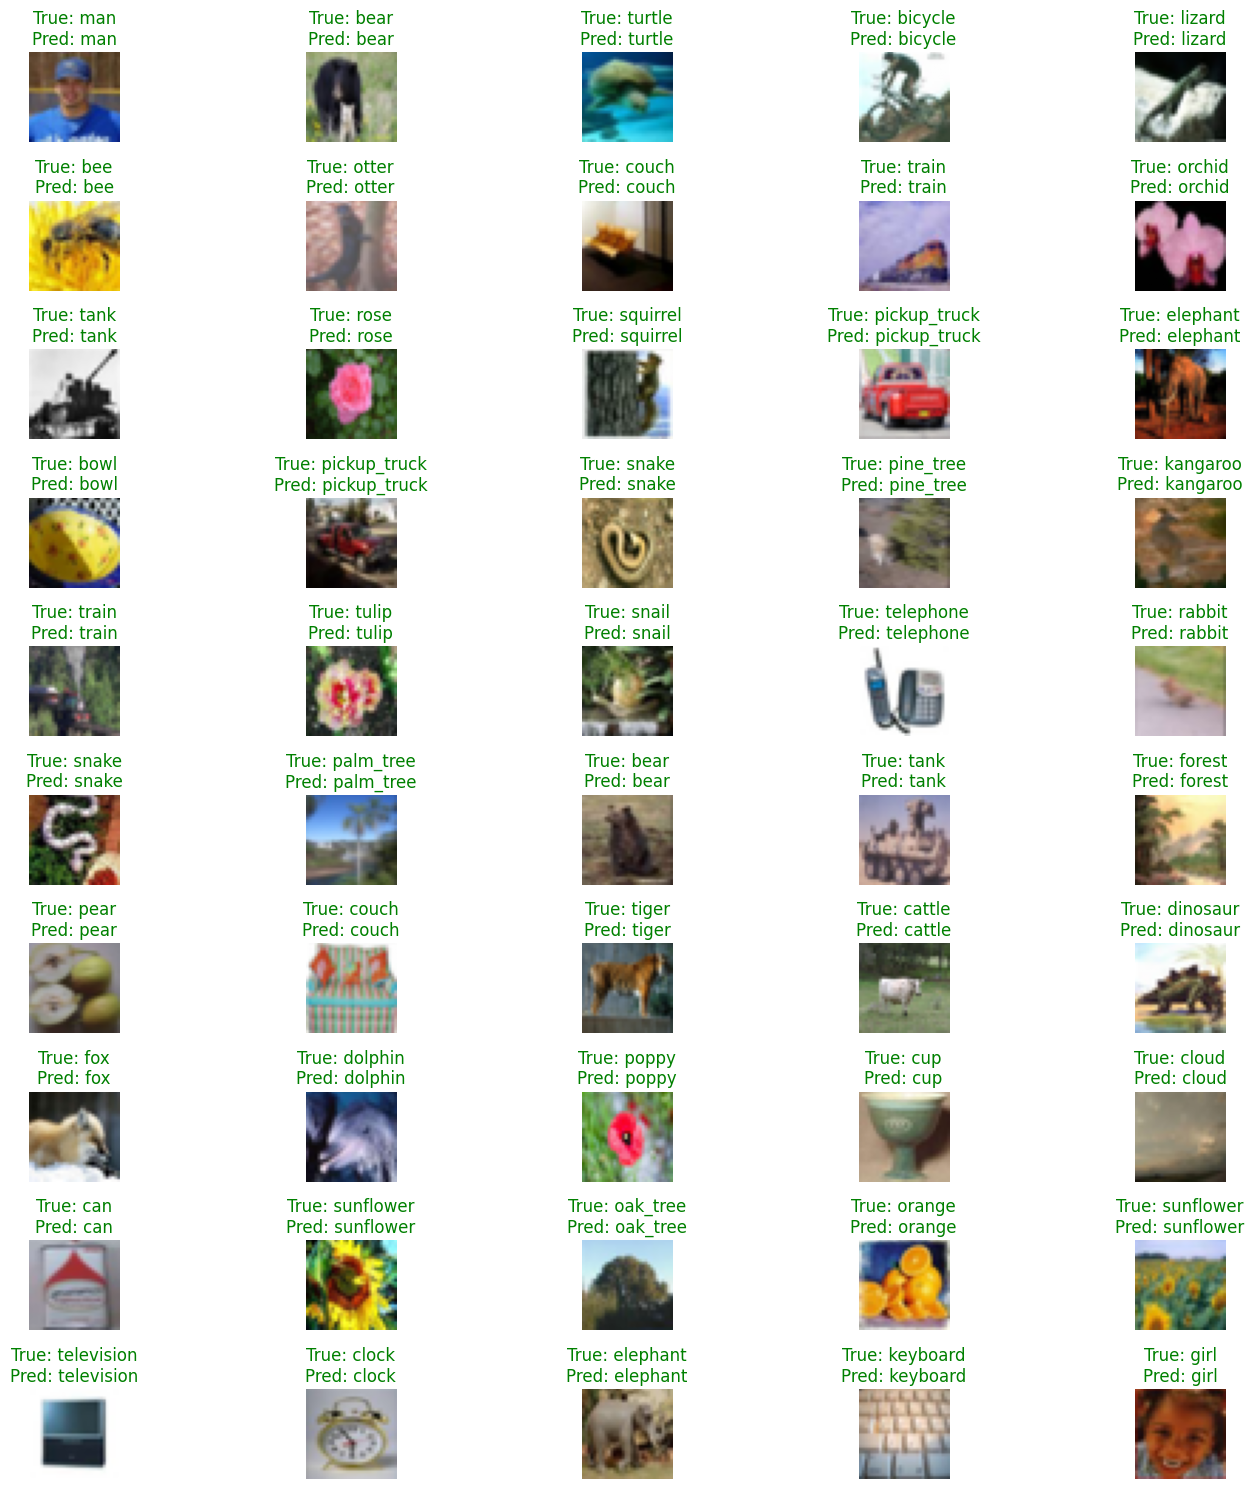

151/157 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-10-26 20:25:11.432561: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1687', 8 bytes spill stores, 8 bytes spill loads



157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


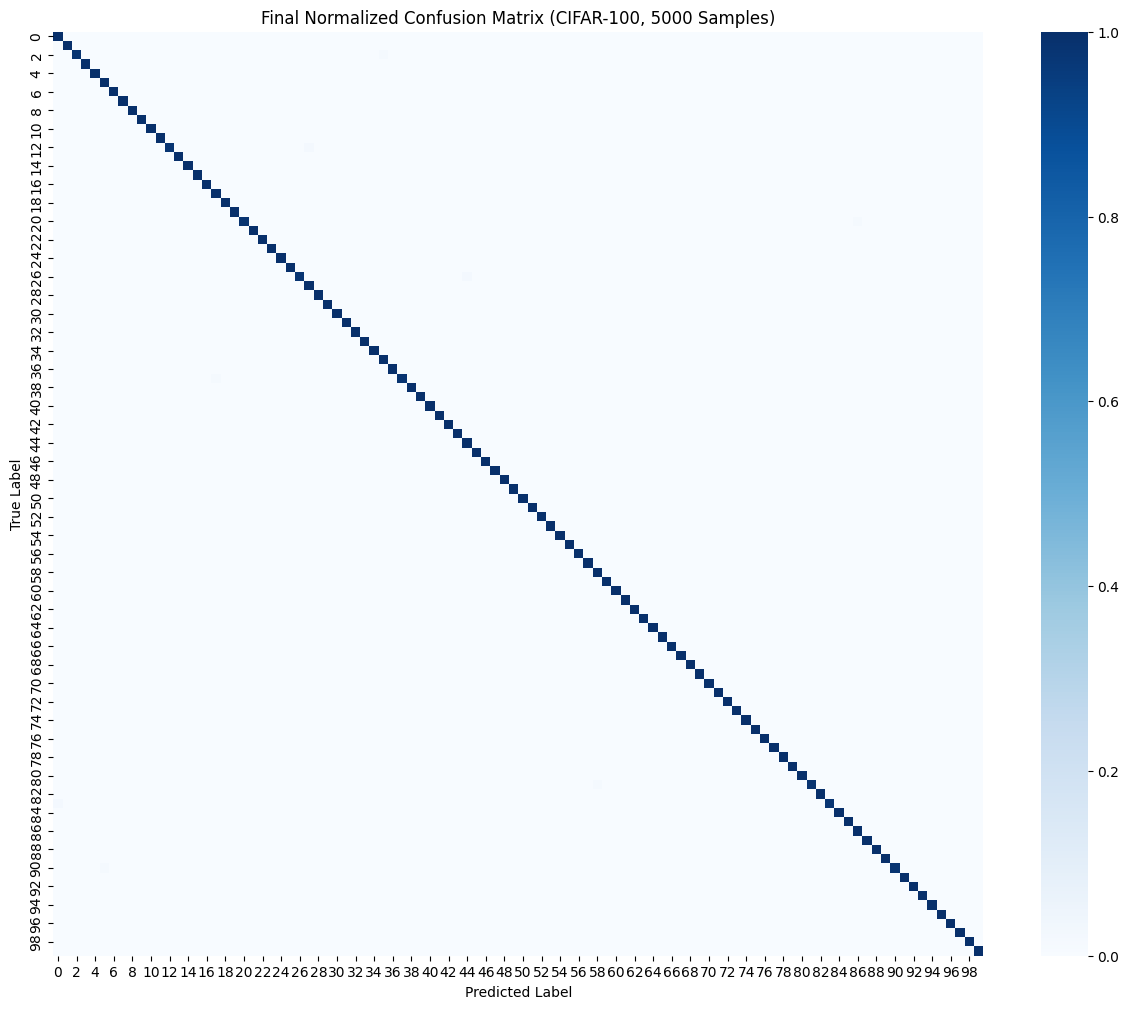

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---------------------------------------------------------------------
# 🔹 Save the Trained Model (Modern .keras format)
# ---------------------------------------------------------------------
model_filename = "cifar100_resnet50_model.keras"
trained_model.save(model_filename)
print(f"✅ Model saved as {model_filename}")

# ---------------------------------------------------------------------
# 🔹 CIFAR-100 Label Names (Human-Readable)
# ---------------------------------------------------------------------
cifar100_label_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# ---------------------------------------------------------------------
# 🔹 Display 50 Random Predictions vs True Labels
# ---------------------------------------------------------------------
num_samples = 50
indices = random.sample(range(len(final_x_test)), num_samples)

y_true = np.argmax(final_y_test, axis=1)
y_pred = np.argmax(trained_model.predict(final_x_test), axis=1)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(indices):
    image = final_x_test[idx]
    true_label = cifar100_label_names[y_true[idx]]
    predicted_label = cifar100_label_names[y_pred[idx]]

    plt.subplot(10, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")
    color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 🔹 Confusion Matrix (subset of 5000 test samples)
# ---------------------------------------------------------------------
num_test_samples = 5000
random_indices = np.random.choice(len(final_x_test), num_test_samples, replace=False)

x_test_subset = final_x_test[random_indices]
y_test_subset = np.argmax(final_y_test[random_indices], axis=1)
y_pred_subset = np.argmax(trained_model.predict(x_test_subset), axis=1)

cm = confusion_matrix(y_test_subset, y_pred_subset, labels=np.arange(100))
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15, 12))
sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap="Blues")
plt.title("Final Normalized Confusion Matrix (CIFAR-100, 5000 Samples)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
